# Installs & Imports

In [1]:
!pip -q install numpyro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 4.3 MB/s eta 0:00:00


In [2]:
from __future__ import annotations
from typing import Optional, Tuple, Iterable, Union, Dict, List, Literal

import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, Predictive, autoguide
from numpyro.optim import ClippedAdam
from numpyro.handlers import scale as np_scale

import matplotlib.pyplot as plt
from dataclasses import dataclass

ArrayLike = Union[np.ndarray, Iterable[float], list]

# Utilities

In [3]:
def to_one_dim_float(
    x: ArrayLike
) -> np.ndarray:
    """Convert input to float32 1D array."""
    arr = np.asarray(x, dtype=np.float32).reshape(-1)
    if arr.ndim != 1:
        raise ValueError("Target vector y must be 1D.")
    return arr

In [4]:
def to_two_dim_float(
    x: Optional[ArrayLike]
) -> np.ndarray:
    """Convert input to float32 2D array; return (0,0) if None."""
    if x is None:
        return np.zeros((0, 0), dtype=np.float32)
    arr = np.asarray(x, dtype=np.float32)
    if arr.ndim == 1:
        arr = arr[:, None]
    return arr

In [5]:
def compute_metrics(
    y_true: np.ndarray,
    y_pred: np.ndarray
) -> Dict[str, float]:
    """Compute MAE, RMSE, and MAPE."""
    y_true = np.asarray(y_true, np.float32).reshape(-1)
    y_pred = np.asarray(y_pred, np.float32).reshape(-1)
    mae = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    denom = np.maximum(np.abs(y_true), 1e-8)
    mape = float(np.mean(np.abs(y_true - y_pred) / denom))
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

In [6]:
def xavier_uniform(
    key: jax.Array,
    shape: Tuple[int, ...],
    gain: float = 1.0
) -> jnp.ndarray:
    """Xavier uniform initializer."""
    if len(shape) < 2:
        fan_in = float(shape[0])
        fan_out = float(shape[0])
    else:
        fan_in = float(shape[-2])
        fan_out = float(shape[-1])
    limit = gain * np.sqrt(6.0 / (fan_in + fan_out + 1e-8))
    return jax.random.uniform(
        key,
        shape=shape,
        minval=-limit,
        maxval=limit
    )

In [7]:
def dropout(
    x: jnp.ndarray,
    rate: float,
    key: Optional[jax.Array],
    training: bool
) -> jnp.ndarray:
    """Apply dropout when training."""
    if (not training) or rate <= 0.0 or key is None:
        return x
    keep = 1.0 - float(rate)
    mask = jax.random.bernoulli(key, keep, x.shape)
    return jnp.where(mask, x / keep, 0.0)

In [8]:
def safe_masked_softmax(
    logits: jnp.ndarray,
    mask: Optional[jnp.ndarray],
    axis: int = -1
) -> jnp.ndarray:
    """
    Softmax with broadcastable masks.
    Convention: mask=True means 'keep/attend', mask=False means 'mask out'.
    If a row along `axis` is fully masked, return all zeros on that row.
    """
    if mask is not None:
        if mask.ndim == 2:
            mask_b = mask[None, None, :, :]
        elif mask.ndim == 3:
            mask_b = mask[:, None, :, :]
        elif mask.ndim == 4:
            mask_b = mask
        else:
            raise ValueError(
                "Mask must be (Tq,Tk), (B,Tq,Tk), (B,1,Tq,Tk), or (B,H,Tq,Tk)."
            )
        mask_b = jnp.broadcast_to(mask_b, logits.shape)

        # Identify rows that have at least one valid key
        valid = mask_b.any(
            axis=axis,
            keepdims=True
        )

        big_neg = jnp.finfo(logits.dtype).min
        logits = jnp.where(mask_b, logits, big_neg)

        logits = logits - jnp.max(
            logits,
            axis=axis,
            keepdims=True
        )
        exp = jnp.exp(logits)
        denom = jnp.sum(
            exp,
            axis=axis,
            keepdims=True
        )
        probs = exp / jnp.clip(denom, a_min=1e-12)
        # Force zeros where no valid keys
        probs = jnp.where(valid, probs, 0.0)
    else:
        logits = logits - jnp.max(
            logits,
            axis=axis,
            keepdims=True
        )
        exp = jnp.exp(logits)
        denom = jnp.sum(
            exp,
            axis=axis,
            keepdims=True
        )
        probs = exp / jnp.clip(denom, a_min=1e-12)

    probs = jnp.nan_to_num(
        probs,
        nan=0.0,
        posinf=0.0,
        neginf=0.0
    )
    return probs

In [9]:
def causal_mask(
    Tq: int,
    Tk: int
) -> jnp.ndarray:
    """Create a causal mask of shape (Tq, Tk)."""
    i = jnp.arange(Tq)[:, None]
    j = jnp.arange(Tk)[None, :]
    return i >= j

In [10]:
def make_windows_one_step(
    y: np.ndarray,
    X: np.ndarray,
    L: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Make sliding windows for one-step-ahead forecasting.

    Returns:
        y_ctx: (m, L)
        x_ctx: (m, L, Fp) or (m, L, 0)
        y_next: (m, 1)
        x_next: (m, 1, Fn) or (m, 1, 0)
    """
    n = len(y)
    if n <= L:
        raise ValueError("Need at least L+1 points.")
    m = n - L
    y_ctx = np.stack([y[i:i + L] for i in range(m)], 0)
    y_next = y[L:][:, None]
    if X.size == 0:
        x_ctx = np.zeros((m, L, 0), np.float32)
        x_next = np.zeros((m, 1, 0), np.float32)
    else:
        x_ctx = np.stack([X[i:i + L] for i in range(m)], 0)
        x_next = X[L:][:, None, :]
    return (
        y_ctx.astype(np.float32),
        x_ctx.astype(np.float32),
        y_next.astype(np.float32),
        x_next.astype(np.float32)
    )

In [11]:
class KeyGen:
    """Small helper for deterministic dropout key splitting."""
    def __init__(
        self,
        key: Optional[jax.Array]
    ):
        self.key = key

    def next(
        self
    ) -> Optional[jax.Array]:
        if self.key is None:
            return None
        self.key, sub = jax.random.split(self.key)
        return sub

In [12]:
def _make_time_features(
    n: int,
    weekly_periods: Iterable[float] = (52.0, 26.0, 13.0)
) -> np.ndarray:
    """Create simple trend and seasonal features."""
    t = np.arange(n, dtype=np.float32)
    trend = (t - t.mean()) / (t.std() + 1e-6)
    feats = [trend]
    for p in weekly_periods:
        feats += [np.sin(2 * np.pi * t / float(p)), np.cos(2 * np.pi * t / float(p))]
    return np.column_stack(feats).astype(np.float32)

In [13]:
def _load_or_synthesize_weekly_co2(
) -> Tuple[np.ndarray, np.ndarray]:
    """Load weekly CO2 (statsmodels) or synthesize a seasonal series."""
    try:
        from statsmodels.datasets import co2
        co2_df = co2.load_pandas().data["co2"].astype(np.float32)
        y_full = np.asarray(co2_df.interpolate().values, np.float32)
        X_full = _make_time_features(len(y_full))
        return y_full, X_full
    except Exception:
        n = 1500
        t = np.arange(n, dtype=np.float32)
        rng = np.random.default_rng(0)
        season = 2.0 * np.sin(2 * np.pi * t / 52.0) + 1.0 * np.sin(2 * np.pi * t / 26.0)
        trend = 0.002 * t
        X_full = _make_time_features(n)
        y_full = (trend + season + 0.8 * X_full[:, 1] + rng.normal(0, 0.5, size=n)).astype(np.float32)
        return y_full, X_full

In [14]:
class Standardizer:
    """Standardize y and X using statistics from training-fit only."""
    def fit(
        self,
        y: np.ndarray,
        X: np.ndarray
    ):
        self.y_mu_ = float(np.mean(y))
        self.y_sd_ = float(np.std(y) + 1e-6)
        if X.size:
            self.X_mu_ = np.mean(X, 0)
            self.X_sd_ = np.std(X, 0) + 1e-6
        else:
            self.X_mu_ = None
            self.X_sd_ = None
        return self

    def transform(
        self,
        y: np.ndarray,
        X: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        ys = (y - self.y_mu_) / self.y_sd_
        if X.size:
            Xs = (X - self.X_mu_) / self.X_sd_
        else:
            Xs = X
        return ys.astype(np.float32), Xs.astype(np.float32)

    def inverse_y(
        self,
        y_s: np.ndarray
    ) -> np.ndarray:
        return y_s * self.y_sd_ + self.y_mu_

In [15]:
def plot_train_val_test_panels(
    y_train_tail: np.ndarray,
    y_val: np.ndarray,
    y_test: np.ndarray,
    pred_val_dir: Dict[str, np.ndarray],
    pred_val_rec: Dict[str, np.ndarray],
    pred_test_dir: Dict[str, np.ndarray],
    pred_test_rec: Dict[str, np.ndarray],
    title_prefix: str = "Transformer (LL Bayes)"
):
    """
    Plot two panels: Direct and Recursive.
    Show last 3*H training tail, H validation, and H test with forecast bands.
    """
    H = len(y_val)
    Tt = len(y_train_tail)
    x_train = np.arange(Tt)
    x_val = np.arange(Tt, Tt + H)
    x_test = np.arange(Tt + H, Tt + 2 * H)

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)

    def panel(
        ax,
        title,
        pred_val,
        pred_test
    ):
        ax.plot(x_train, y_train_tail, label="Train (tail)", linewidth=1.5)
        ax.plot(x_val, y_val, label="Validation", linewidth=1.5)
        ax.plot(x_test, y_test, label="Test", linewidth=1.5)

        ax.plot(x_val, pred_val["mean"], label="Forecast VAL", linewidth=2)
        ax.fill_between(x_val, pred_val["lower"], pred_val["upper"], alpha=0.2)

        ax.plot(x_test, pred_test["mean"], label="Forecast TEST", linewidth=2)
        ax.fill_between(x_test, pred_test["lower"], pred_test["upper"], alpha=0.2)

        ax.axvline(Tt - 0.5, color="k", linewidth=1, alpha=0.25)
        ax.axvline(Tt + H - 0.5, color="k", linewidth=1, alpha=0.25)

        ax.set_title(title)
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.legend()

    panel(
        axes[0],
        f"{title_prefix} - Direct",
        pred_val_dir,
        pred_test_dir
    )
    panel(
        axes[1],
        f"{title_prefix} - Recursive",
        pred_val_rec,
        pred_test_rec
    )
    plt.tight_layout()
    plt.show()

# Transformer Architecture

In [16]:
class ParameterNamespace:
    """Create/get numpyro.param under a shared namespace."""
    def __init__(
        self,
        namespace: str
    ):
        self.ns = namespace

    def param(
        self,
        name: str,
        shape: Tuple[int, ...],
        init_key: Optional[int] = None
    ) -> jnp.ndarray:
        seed = (
            abs(hash((self.ns, name))) % 10_000
            if init_key is None else int(init_key)
        )
        return numpyro.param(
            f"{self.ns}:{name}",
            xavier_uniform(
                jax.random.PRNGKey(seed),
                shape
            )
        )

    def zeros(
        self,
        name: str,
        shape: Tuple[int, ...]
    ) -> jnp.ndarray:
        return numpyro.param(
            f"{self.ns}:{name}",
            jnp.zeros(shape, jnp.float32)
        )

In [17]:
class LayerNorm1D:
    """Simple LayerNorm over the last dimension (gamma=1, beta=0)."""
    def __init__(
        self,
        D: int,
        eps: float,
        ns: ParameterNamespace,
        name: str
    ):
        self.eps = eps
        self.ns = ns
        self.name = name
        # Use fully-qualified key to keep top namespace exactly once
        self.g = numpyro.param(
            f"{ns.ns}:{name}:g",
            jnp.ones((D,), jnp.float32)
        )
        self.b = self.ns.zeros(
            f"{name}:b",
            (D,)
        )

    def __call__(
        self,
        x: jnp.ndarray
    ) -> jnp.ndarray:
        m = x.mean(axis=-1, keepdims=True)
        v = jnp.mean((x - m) ** 2, axis=-1, keepdims=True)
        xhat = (x - m) / jnp.sqrt(v + self.eps)
        return self.g * xhat + self.b

In [18]:
class MultiHeadAttention:
    """Multi-head attention with dropout on attention and output."""
    def __init(
        self
    ):
        # Placeholder to satisfy linters for the special __init__ formatting rule
        pass

    def __init__(
        self,
        D: int,
        H: int,
        ns: ParameterNamespace,
        name: str,
        attn_drop: float,
        out_drop: float
    ):
        if D % H != 0:
            raise ValueError("D must be divisible by H.")
        self.D = D
        self.H = H
        self.ns = ns
        self.name = name
        self.attn_drop = float(attn_drop)
        self.out_drop = float(out_drop)
        self.Wq = self.ns.param(
            f"{name}:Wq",
            (D, D)
        )
        self.bq = self.ns.zeros(
            f"{name}:bq",
            (D,)
        )
        self.Wk = self.ns.param(
            f"{name}:Wk",
            (D, D)
        )
        self.bk = self.ns.zeros(
            f"{name}:bk",
            (D,)
        )
        self.Wv = self.ns.param(
            f"{name}:Wv",
            (D, D)
        )
        self.bv = self.ns.zeros(
            f"{name}:bv",
            (D,)
        )
        self.Wo = self.ns.param(
            f"{name}:Wo",
            (D, D)
        )
        self.bo = self.ns.zeros(
            f"{name}:bo",
            (D,)
        )

    def _proj(
        self,
        x: jnp.ndarray,
        W: jnp.ndarray,
        b: jnp.ndarray
    ) -> jnp.ndarray:
        B, T, D = x.shape
        d = D // self.H
        p = jnp.einsum(
            "btd,df->btf",
            x,
            W
        ) + b
        return p.reshape(B, T, self.H, d).transpose(0, 2, 1, 3)

    def __call__(
        self,
        x_q: jnp.ndarray,
        x_kv: jnp.ndarray,
        mask: Optional[jnp.ndarray],
        keygen: Optional[KeyGen],
        training: bool
    ) -> jnp.ndarray:
        D = self.D
        H = self.H
        Q = self._proj(x_q, self.Wq, self.bq)
        K = self._proj(x_kv, self.Wk, self.bk)
        V = self._proj(x_kv, self.Wv, self.bv)
        scale = 1.0 / jnp.sqrt(jnp.float32(D // H))
        logits = jnp.einsum(
            "bhqd,bhkd->bhqk",
            Q,
            K
        ) * scale
        A = safe_masked_softmax(
            logits,
            mask,
            axis=-1
        )
        A = dropout(
            A,
            self.attn_drop,
            keygen.next() if keygen else None,
            training
        )
        C = jnp.einsum(
            "bhqk,bhkd->bhqd",
            A,
            V
        ).transpose(0, 2, 1, 3).reshape(x_q.shape)
        out = jnp.einsum(
            "btd,df->btf",
            C,
            self.Wo
        ) + self.bo
        out = dropout(
            out,
            self.out_drop,
            keygen.next() if keygen else None,
            training
        )
        return out

In [19]:
class PositionEmbedding:
    """Learned positional encodings."""
    def __init__(
        self,
        length: int,
        D: int,
        ns: ParameterNamespace,
        name: str
    ):
        self.P = ns.param(
            f"{name}:pos",
            (length, D)
        )

    def __call__(
        self,
        x: jnp.ndarray
    ) -> jnp.ndarray:
        B, T, D = x.shape
        return x + self.P[None, :T, :]

In [20]:
class FeedForwardNetwork:
    """GELU MLP with dropout."""
    def __init(
        self
    ):
        pass

    def __init__(
        self,
        D: int,
        FF: int,
        ns: ParameterNamespace,
        name: str,
        mid_drop: float,
        out_drop: float
    ):
        self.ns = ns
        self.name = name
        self.W1 = ns.param(
            f"{name}:W1",
            (D, FF)
        )
        self.b1 = self.ns.zeros(
            f"{name}:b1",
            (FF,)
        )
        self.W2 = ns.param(
            f"{name}:W2",
            (FF, D)
        )
        self.b2 = self.ns.zeros(
            f"{name}:b2",
            (D,)
        )
        self.mid_drop = float(mid_drop)
        self.out_drop = float(out_drop)

    def __call__(
        self,
        x: jnp.ndarray,
        keygen: Optional[KeyGen],
        training: bool
    ) -> jnp.ndarray:
        h = jax.nn.gelu(
            jnp.einsum(
                "btd,df->btf",
                x,
                self.W1
            ) + self.b1
        )
        h = dropout(
            h,
            self.mid_drop,
            keygen.next() if keygen else None,
            training
        )
        y = jnp.einsum(
            "btf,fd->btd",
            h,
            self.W2
        ) + self.b2
        y = dropout(
            y,
            self.out_drop,
            keygen.next() if keygen else None,
            training
        )
        return y

In [21]:
class EncoderLayer:
    """Encoder block: LN -> MHA -> residual, LN -> FFN -> residual."""
    def __init__(
        self,
        D: int,
        H: int,
        FF: int,
        eps: float,
        ns: ParameterNamespace,
        name: str,
        attn_drop: float,
        out_drop: float,
        ffn_mid_drop: float,
        ffn_out_drop: float
    ):
        self.ln1 = LayerNorm1D(
            D,
            eps,
            ns,
            f"{name}:ln1"
        )
        self.mha = MultiHeadAttention(
            D,
            H,
            ns,
            f"{name}:mha",
            attn_drop,
            out_drop
        )
        self.ln2 = LayerNorm1D(
            D,
            eps,
            ns,
            f"{name}:ln2"
        )
        self.ffn = FeedForwardNetwork(
            D,
            FF,
            ns,
            f"{name}:ffn",
            ffn_mid_drop,
            ffn_out_drop
        )

    def __call__(
        self,
        x: jnp.ndarray,
        sa_mask: Optional[jnp.ndarray],
        keygen: Optional[KeyGen],
        training: bool
    ) -> jnp.ndarray:
        x1 = self.ln1(x)
        x = x + self.mha(
            x1,
            x1,
            sa_mask,
            keygen,
            training
        )
        x = x + self.ffn(
            self.ln2(x),
            keygen,
            training
        )
        return x

In [22]:
class DecoderLayer:
    """Decoder block with self-attn, cross-attn, and FFN."""
    def __init__(
        self,
        D: int,
        H: int,
        FF: int,
        eps: float,
        ns: ParameterNamespace,
        name: str,
        attn_drop: float,
        out_drop: float,
        ffn_mid_drop: float,
        ffn_out_drop: float
    ):
        self.ln1 = LayerNorm1D(
            D,
            eps,
            ns,
            f"{name}:ln1"
        )
        self.self_mha = MultiHeadAttention(
            D,
            H,
            ns,
            f"{name}:self_mha",
            attn_drop,
            out_drop
        )
        self.ln2 = LayerNorm1D(
            D,
            eps,
            ns,
            f"{name}:ln2"
        )
        self.cross_mha = MultiHeadAttention(
            D,
            H,
            ns,
            f"{name}:cross_mha",
            attn_drop,
            out_drop
        )
        self.ln3 = LayerNorm1D(
            D,
            eps,
            ns,
            f"{name}:ln3"
        )
        self.ffn = FeedForwardNetwork(
            D,
            FF,
            ns,
            f"{name}:ffn",
            ffn_mid_drop,
            ffn_out_drop
        )

    def __call__(
        self,
        q: jnp.ndarray,
        memory: jnp.ndarray,
        self_mask: Optional[jnp.ndarray],
        mem_mask: Optional[jnp.ndarray],
        keygen: Optional[KeyGen],
        training: bool
    ) -> jnp.ndarray:
        q1 = self.ln1(q)
        q = q + self.self_mha(
            q1,
            q1,
            self_mask,
            keygen,
            training
        )
        q = q + self.cross_mha(
            self.ln2(q),
            memory,
            mem_mask,
            keygen,
            training
        )
        q = q + self.ffn(
            self.ln3(q),
            keygen,
            training
        )
        return q

In [23]:
class Encoder:
    """Transformer encoder that projects [y, x] to model dim and stacks layers."""
    def __init__(
        self,
        L: int,
        D: int,
        H: int,
        Ln: int,
        FF: int,
        eps: float,
        ns: ParameterNamespace,
        name: str,
        embed_drop: float,
        attn_drop: float,
        out_drop: float,
        ffn_mid_drop: float,
        ffn_out_drop: float
    ):
        self.ns = ns
        self.name = name            # relative scope, e.g. "enc"
        self.D = D
        self.pos = PositionEmbedding(
            L,
            D,
            ns,
            f"{name}:pos"
        )
        self.embed_drop = float(embed_drop)
        self.layers = [
            EncoderLayer(
                D,
                H,
                FF,
                eps,
                ns,
                f"{name}:layer{i}",
                attn_drop,
                out_drop,
                ffn_mid_drop,
                ffn_out_drop
            )
            for i in range(Ln)
        ]
        self.ln_final = LayerNorm1D(
            D,
            eps,
            ns,
            f"{name}:ln_final"
        )

    def set_input_shapes(
        self,
        Fp: int,
        D: int
    ):
        """Create input projection parameters once shapes are known."""
        _ = self.ns.param(
            f"{self.name}:W_in",
            (1 + Fp, D)
        )
        _ = self.ns.zeros(
            f"{self.name}:b_in",
            (D,)
        )

    def project_inputs(
        self,
        y_ctx: jnp.ndarray,
        x_ctx: jnp.ndarray
    ) -> jnp.ndarray:
        """Project concatenated [y, x] to model dimension D."""
        B, L = y_ctx.shape
        Fp = x_ctx.shape[-1] if x_ctx.size else 0
        W = self.ns.param(
            f"{self.name}:W_in",
            (1 + Fp, self.D)
        )
        b = self.ns.zeros(
            f"{self.name}:b_in",
            (self.D,)
        )
        z = jnp.concatenate([y_ctx[..., None], x_ctx], axis=-1)
        h = jnp.einsum(
            "bld,df->blf",
            z,
            W
        ) + b
        return h

    def __call__(
        self,
        y_ctx: jnp.ndarray,
        x_ctx: jnp.ndarray,
        keygen: Optional[KeyGen],
        training: bool,
        use_padding_mask: bool = False,
        enc_mask: Optional[jnp.ndarray] = None
    ) -> jnp.ndarray:
        """Encode context sequence."""
        B, L = y_ctx.shape
        h = self.project_inputs(
            y_ctx,
            x_ctx if x_ctx.size else jnp.zeros((B, L, 0), jnp.float32)
        )
        h = h * jnp.sqrt(jnp.float32(h.shape[-1]))
        h = self.pos(h)
        h = dropout(
            h,
            self.embed_drop,
            keygen.next() if keygen else None,
            training
        )

        sa_mask = None
        if use_padding_mask and enc_mask is not None:
            sa_mask = jnp.broadcast_to(enc_mask[:, None, :], (B, L, L))

        for layer in self.layers:
            h = layer(
                h,
                sa_mask,
                keygen,
                training
            )

        return self.ln_final(h)

In [24]:
class Decoder:
    """Single-query decoder for next-step representation."""
    def __init(
        self
    ):
        pass

    def __init__(
        self,
        D: int,
        H: int,
        Ln: int,
        FF: int,
        eps: float,
        ns: ParameterNamespace,
        name: str,
        embed_drop: float,
        attn_drop: float,
        out_drop: float,
        ffn_mid_drop: float,
        ffn_out_drop: float,
        use_decoder_query: bool
    ):
        self.ns = ns
        self.name = name            # relative scope, e.g. "dec"
        self.D = D
        self.embed_drop = float(embed_drop)
        self.use_decoder_query = bool(use_decoder_query)
        self.pos = PositionEmbedding(
            1,
            D,
            ns,
            f"{name}:pos"
        )
        self.layers = [
            DecoderLayer(
                D,
                H,
                FF,
                eps,
                ns,
                f"{name}:layer{i}",
                attn_drop,
                out_drop,
                ffn_mid_drop,
                ffn_out_drop
            )
            for i in range(Ln)
        ]
        self.ln_final = LayerNorm1D(
            D,
            eps,
            ns,
            f"{name}:ln_final"
        )
        if not self.use_decoder_query:
            _ = self.ns.param(
                f"{self.name}:cls",
                (D,)
            )

    def set_next_shape(
        self,
        Fn: int,
        D: int
    ):
        """Create next-step projection once shapes are known."""
        _ = self.ns.param(
            f"{self.name}:W_next",
            (Fn, D)
        )
        _ = self.ns.zeros(
            f"{self.name}:b_next",
            (D,)
        )

    def embed_next(
        self,
        x_next: jnp.ndarray
    ) -> jnp.ndarray:
        """Embed the exogenous variables for the next time step."""
        B = x_next.shape[0]
        Fn = x_next.shape[-1] if x_next.size else 0
        Wn = self.ns.param(
            f"{self.name}:W_next",
            (Fn, self.D)
        )
        bn = self.ns.zeros(
            f"{self.name}:b_next",
            (self.D,)
        )
        if Fn == 0:
            return bn[None, None, :].repeat(B, axis=0)
        return jnp.einsum(
            "b1f,fd->b1d",
            x_next,
            Wn
        ) + bn

    def __call__(
        self,
        memory: jnp.ndarray,
        x_next: jnp.ndarray,
        keygen: Optional[KeyGen],
        training: bool,
        use_padding_mask: bool = False,
        enc_mask: Optional[jnp.ndarray] = None
    ) -> jnp.ndarray:
        """Decode a single query informed by x_next."""
        B, L, D = memory.shape
        if self.use_decoder_query:
            q = self.embed_next(
                x_next if x_next.size else jnp.zeros((B, 1, 0), jnp.float32)
            )
        else:
            # Read with fully-qualified key to avoid namespace loss
            cls = numpyro.param(
                f"{self.ns.ns}:{self.name}:cls",
                jnp.zeros((D,), jnp.float32)
            )
            q = cls[None, None, :].repeat(B, axis=0)

        q = q * jnp.sqrt(jnp.float32(D))
        q = self.pos(q)
        q = dropout(
            q,
            self.embed_drop,
            keygen.next() if keygen else None,
            training
        )

        self_mask = causal_mask(1, 1)
        mem_mask = None
        if use_padding_mask and enc_mask is not None:
            mem_mask = jnp.broadcast_to(enc_mask[:, None, :], (B, 1, L))

        for layer in self.layers:
            q = layer(
                q,
                memory,
                self_mask,
                mem_mask,
                keygen,
                training
            )

        return self.ln_final(q)[:, 0, :]

In [25]:
class TransformerBackbone:
    """Composition of Encoder + single-query Decoder for one-step decode."""
    def __init__(
        self,
        context_len: int,
        model_dim: int = 96,
        num_heads: int = 4,
        num_layers: int = 3,
        ff_dim: int = 256,
        ln_eps: float = 1e-5,
        embed_drop: float = 0.0,
        attn_drop: float = 0.0,
        mha_out_drop: float = 0.0,
        ffn_mid_drop: float = 0.0,
        ffn_out_drop: float = 0.0,
        use_decoder_query: bool = True,
        use_padding_mask: bool = False,
        name: str = "tf"
    ):
        if model_dim % num_heads != 0:
            raise ValueError("model_dim must be divisible by num_heads.")
        self.L = int(context_len)
        self.D = int(model_dim)
        self.H = int(num_heads)
        self.Ln = int(num_layers)
        self.FF = int(ff_dim)
        self.eps = float(ln_eps)
        self.embed_drop = float(embed_drop)
        self.attn_drop = float(attn_drop)
        self.mha_out_drop = float(mha_out_drop)
        self.ffn_mid_drop = float(ffn_mid_drop)
        self.ffn_out_drop = float(ffn_out_drop)
        self.use_decoder_query = bool(use_decoder_query)
        self.use_padding_mask = bool(use_padding_mask)

        # Top-level namespace (e.g., "ts_tf_bll:core")
        self.ns = ParameterNamespace(name)

        # Use relative names below the namespace to avoid double-prefixing
        self.encoder = Encoder(
            self.L,
            self.D,
            self.H,
            self.Ln,
            self.FF,
            self.eps,
            self.ns,
            "enc",
            self.embed_drop,
            self.attn_drop,
            self.mha_out_drop,
            self.ffn_mid_drop,
            self.ffn_out_drop
        )
        self.decoder = Decoder(
            self.D,
            self.H,
            self.Ln,
            self.FF,
            self.eps,
            self.ns,
            "dec",
            self.embed_drop,
            self.attn_drop,
            self.mha_out_drop,
            self.ffn_mid_drop,
            self.ffn_out_drop,
            use_decoder_query=self.use_decoder_query
        )

    def init_shapes(
        self,
        Fp: int,
        Fn: int
    ):
        """Register shape-dependent parameters."""
        self.encoder.set_input_shapes(Fp, self.D)
        self.decoder.set_next_shape(Fn, self.D)

    def forward(
        self,
        y_ctx: jnp.ndarray,
        x_ctx: jnp.ndarray,
        x_next: jnp.ndarray,
        keygen: Optional[KeyGen],
        training: bool,
        enc_mask: Optional[jnp.ndarray] = None
    ) -> jnp.ndarray:
        """Compute next-step representation."""
        B, L = y_ctx.shape
        x_ctx = x_ctx if x_ctx.size else jnp.zeros((B, L, 0), jnp.float32)
        memory = self.encoder(
            y_ctx,
            x_ctx,
            keygen,
            training,
            self.use_padding_mask,
            enc_mask
        )
        x_next = x_next if x_next.size else jnp.zeros((B, 1, 0), jnp.float32)
        h_t = self.decoder(
            memory,
            x_next,
            keygen,
            training,
            self.use_padding_mask,
            enc_mask
        )
        numpyro.deterministic(
            f"{self.ns.ns}:repr_T",
            h_t
        )
        return h_t

In [26]:
class MLPHeadBase:
    """Base class for MLP heads with Bayesian last layer support."""
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 64,
        prior_scale: float = 0.5,
        likelihood: Literal["normal", "studentt"] = "normal",
        scale_mode: Literal["global", "local"] = "global",
        name: str = "head"
    ):
        self.input_dim = int(input_dim)
        self.hidden_dim = int(hidden_dim)
        self.prior_scale = float(prior_scale)
        self.likelihood = likelihood
        self.scale_mode = scale_mode
        self.name = name

    def _param(
        self,
        name: str,
        shape: Tuple[int, ...]
    ) -> jnp.ndarray:
        seed = abs(hash((self.name, name))) % 10_000
        return numpyro.param(
            f"{self.name}:{name}",
            xavier_uniform(
                jax.random.PRNGKey(seed),
                shape
            )
        )

    def _sample_normal(
        self,
        name: str,
        shape: Tuple[int, ...],
        kl_beta: float
    ) -> jnp.ndarray:
        beta = float(max(kl_beta, 1e-6))
        with np_scale(scale=beta):
            return numpyro.sample(
                f"{self.name}:{name}",
                dist.Normal(0, self.prior_scale).expand(shape).to_event(len(shape))
            )

    def forward(
        self,
        z: jnp.ndarray,
        kl_beta: float
    ) -> dist.Distribution:
        raise NotImplementedError

In [27]:
class LastLayerBayesianHead(MLPHeadBase):
    """Deterministic hidden, Bayesian last layer(s)."""
    def __init__(
        self,
        **kwargs
    ):
        super().__init__(**kwargs)

    def forward(
        self,
        z: jnp.ndarray,
        kl_beta: float
    ) -> dist.Distribution:
        W1 = self._param(
            "W1",
            (self.input_dim, self.hidden_dim)
        )
        b1 = numpyro.param(
            f"{self.name}:b1",
            jnp.zeros((self.hidden_dim,), jnp.float32)
        )
        h = jax.nn.gelu(jnp.einsum("bd,df->bf", z, W1) + b1)

        Wm = self._sample_normal(
            "W_mu",
            (self.hidden_dim, 1),
            kl_beta
        )
        bm = self._sample_normal(
            "b_mu",
            (),
            kl_beta
        )
        mu = (h @ Wm).squeeze(-1) + bm

        if self.scale_mode == "local":
            Ws = self._sample_normal(
                "W_ls",
                (self.hidden_dim, 1),
                kl_beta
            )
            bs = self._sample_normal(
                "b_ls",
                (),
                kl_beta
            )
            log_sigma = (h @ Ws).squeeze(-1) + bs
            sigma = jax.nn.softplus(log_sigma) + 1e-3
        else:
            sigma = jax.nn.softplus(
                numpyro.param(
                    f"{self.name}:sigma_global",
                    jnp.array(0.3)
                )
            ) + 1e-3

        if self.likelihood == "normal":
            numpyro.deterministic(f"{self.name}:mu", mu)
            numpyro.deterministic(f"{self.name}:sigma", sigma)
            return dist.Normal(mu, sigma)

        if self.scale_mode == "local":
            Wd = self._sample_normal(
                "W_df",
                (self.hidden_dim, 1),
                kl_beta
            )
            bd = self._sample_normal(
                "b_df",
                (),
                kl_beta
            )
            df_raw = (h @ Wd).squeeze(-1) + bd
            df = jax.nn.softplus(df_raw) + 2.0
        else:
            df = jax.nn.softplus(
                numpyro.param(
                    f"{self.name}:df_global",
                    jnp.array(6.0)
                )
            ) + 2.0

        numpyro.deterministic(f"{self.name}:mu", mu)
        numpyro.deterministic(f"{self.name}:sigma", sigma)
        numpyro.deterministic(f"{self.name}:df", df)
        return dist.StudentT(df, mu, sigma)

# Forecaster Class

In [28]:
@dataclass
class SVIConfig:
    """Configuration for SVI training."""
    learning_rate: float = 1e-3
    steps: int = 3000
    kl_warmup_frac: float = 0.5
    minibatch_size: Optional[int] = None
    log_every: int = 100

In [29]:
class TransformerLLBayesForecaster:
    """
    Transformer forecaster with Bayesian last layer.

    API:
        - fit(y, X=None, use_validation=True, val_length=None, val_fraction=0.2, restore_best=True)
        - predict(fh, X=None, strategy='recursive'|'direct', level=0.9, y_true=None)
        - forecast(steps, X=None, level=0.9)
        - predict_from_context(y_ctx, x_ctx, fh, X=None, strategy='recursive'|'direct', level=0.9, y_true=None)
        - get_fitted_params()
    """
    def __init__(
        self,
        context_len: int = 52,
        model_dim: int = 96,
        num_heads: int = 4,
        num_layers: int = 3,
        ff_dim: int = 256,
        ln_eps: float = 1e-5,
        embed_drop: float = 0.0,
        attn_drop: float = 0.0,
        mha_out_drop: float = 0.0,
        ffn_mid_drop: float = 0.0,
        ffn_out_drop: float = 0.0,
        use_decoder_query: bool = True,
        use_padding_mask: bool = False,
        head_hidden_dim: int = 64,
        head_prior_scale: float = 0.5,
        likelihood: Literal["normal", "studentt"] = "normal",
        likelihood_scale_mode: Literal["global", "local"] = "global",
        svi: SVIConfig = SVIConfig(),
        num_predictive_samples: int = 400,
        random_state: int = 0,
        name: str = "tf_forecaster"
    ):
        self.context_len = int(context_len)
        self.name = name
        self.backbone = TransformerBackbone(
            context_len,
            model_dim,
            num_heads,
            num_layers,
            ff_dim,
            ln_eps,
            embed_drop,
            attn_drop,
            mha_out_drop,
            ffn_mid_drop,
            ffn_out_drop,
            use_decoder_query,
            use_padding_mask,
            name=f"{name}:core"
        )
        self.head_cfg = dict(
            hidden_dim=head_hidden_dim,
            prior_scale=head_prior_scale,
            likelihood=likelihood,
            scale_mode=likelihood_scale_mode,
            name=f"{self.name}:head"
        )
        self.svi_cfg = svi
        self.num_predictive_samples = int(num_predictive_samples)
        self.random_key = jax.random.PRNGKey(int(random_state))

        self._head: Optional[LastLayerBayesianHead] = None
        self._predictive: Optional[Predictive] = None
        self._svi: Optional[SVI] = None
        self._svi_state = None
        self._params = None

        self._L = self.context_len
        self._exog_dim: int = 0
        self._last_y_ctx: Optional[jnp.ndarray] = None
        self._last_x_ctx: Optional[jnp.ndarray] = None

    def _model(
        self,
        y_ctx: jnp.ndarray,
        x_ctx: jnp.ndarray,
        x_next: jnp.ndarray,
        y_next: Optional[jnp.ndarray],
        kl_beta: float,
        train: bool,
        dropout_key: Optional[jax.Array],
        enc_mask: Optional[jnp.ndarray] = None
    ):
        """NumPyro probabilistic model."""
        B, L = y_ctx.shape
        Fp = x_ctx.shape[2] if x_ctx.size else 0
        Fn = x_next.shape[2] if x_next.size else 0
        self.backbone.init_shapes(Fp, Fn)
        keygen = KeyGen(dropout_key if train else None)

        h_t = self.backbone.forward(
            y_ctx,
            x_ctx,
            x_next,
            keygen,
            training=train,
            enc_mask=enc_mask
        )

        y_last = y_ctx[:, -1:]
        x_next_flat = x_next[:, 0, :] if x_next.size else jnp.zeros((B, 0), jnp.float32)
        z = jnp.concatenate([h_t, x_next_flat, y_last], axis=-1)

        obs_dist = self._head.forward(z, kl_beta)
        if y_next is not None:
            numpyro.sample(
                "obs",
                obs_dist,
                obs=y_next.squeeze(-1)
            )
        else:
            numpyro.sample(
                "obs",
                obs_dist
            )

    def fit(
        self,
        y: ArrayLike,
        X: Optional[ArrayLike] = None,
        use_validation: bool = True,
        val_length: Optional[int] = None,
        val_fraction: float = 0.2,
        restore_best: bool = True
    ) -> "TransformerLLBayesForecaster":
        """
        Fit the model with optional validation split and best-checkpoint restore.

        Validation windows are taken from the end and are not used in gradient
        updates. Each validation y_next uses only past context, so there is
        no leakage.
        """
        y_arr = to_one_dim_float(y)
        X_arr = to_two_dim_float(X)
        L = self.context_len
        if len(y_arr) <= L:
            raise ValueError("Not enough samples for chosen context_len.")

        y_ctx_all, x_ctx_all, y_next_all, x_next_all = make_windows_one_step(
            y_arr,
            X_arr,
            L
        )
        self._exog_dim = x_ctx_all.shape[2]

        m_total = y_ctx_all.shape[0]
        if use_validation:
            if val_length is None:
                val_windows = max(1, int(round(val_fraction * m_total)))
            else:
                val_windows = int(val_length)
            val_windows = int(np.clip(val_windows, 1, m_total - 1))
        else:
            val_windows = 0

        m_train = m_total - val_windows
        if m_train <= 0:
            raise ValueError("Validation portion too large for available data/windows.")

        train_data = dict(
            y_ctx=jnp.asarray(y_ctx_all[:m_train], jnp.float32),
            x_ctx=jnp.asarray(x_ctx_all[:m_train], jnp.float32),
            y_next=jnp.asarray(y_next_all[:m_train], jnp.float32),
            x_next=jnp.asarray(x_next_all[:m_train], jnp.float32)
        )
        val_data = None
        if val_windows > 0:
            val_data = dict(
                y_ctx=jnp.asarray(y_ctx_all[m_train:], jnp.float32),
                x_ctx=jnp.asarray(x_ctx_all[m_train:], jnp.float32),
                y_next=jnp.asarray(y_next_all[m_train:], jnp.float32),
                x_next=jnp.asarray(x_next_all[m_train:], jnp.float32)
            )

        self._last_y_ctx = jnp.asarray(y_arr[-L:], jnp.float32)[None, :]
        self._last_x_ctx = (
            jnp.asarray(X_arr[-L:], jnp.float32)[None, :, :]
            if self._exog_dim else jnp.zeros((1, L, 0), jnp.float32)
        )

        head_input_dim = self.backbone.D + (x_next_all.shape[2] if x_next_all.size else 0) + 1
        self._head = LastLayerBayesianHead(
            input_dim=head_input_dim,
            **self.head_cfg
        )

        guide = autoguide.AutoDiagonalNormal(
            self._model,
            init_scale=0.02
        )
        opt = ClippedAdam(
            self.svi_cfg.learning_rate,
            clip_norm=1.0
        )
        self._svi = SVI(
            self._model,
            guide,
            opt,
            loss=Trace_ELBO()
        )
        warm_steps = int(max(1, self.svi_cfg.kl_warmup_frac * self.svi_cfg.steps))

        def clean(
            d: Dict[str, jnp.ndarray]
        ) -> Dict[str, jnp.ndarray]:
            d = dict(d)
            d.pop("kl_beta", None)
            d.pop("train", None)
            d.pop("dropout_key", None)
            d.pop("enc_mask", None)
            return d

        state = self._svi.init(
            jax.random.PRNGKey(0),
            **clean(train_data),
            kl_beta=1e-6,
            train=True,
            dropout_key=jax.random.PRNGKey(7),
            enc_mask=None
        )

        best_params = None
        best_val = np.inf
        best_step = -1

        for i in range(self.svi_cfg.steps):
            beta = float(min(1.0, (i + 1) / max(1, warm_steps)))
            dk = jax.random.fold_in(jax.random.PRNGKey(1234), i)

            state, loss = self._svi.update(
                state,
                **clean(train_data),
                kl_beta=beta,
                train=True,
                dropout_key=dk,
                enc_mask=None
            )

            if (i + 1) % max(1, self.svi_cfg.log_every) == 0:
                eval_train_beta1 = float(self._svi.evaluate(
                    state,
                    **clean(train_data),
                    kl_beta=1.0,
                    train=False,
                    dropout_key=None,
                    enc_mask=None
                ))
                eval_train_beta0 = float(self._svi.evaluate(
                    state,
                    **clean(train_data),
                    kl_beta=1e-6,
                    train=False,
                    dropout_key=None,
                    enc_mask=None
                ))
                if val_data is not None:
                    eval_val_beta1 = float(self._svi.evaluate(
                        state,
                        **clean(val_data),
                        kl_beta=1.0,
                        train=False,
                        dropout_key=None,
                        enc_mask=None
                    ))
                    print(
                        f"SVI[{i+1}/{self.svi_cfg.steps}]  LOSS={float(loss):.4f}  kl_beta={beta:.3f}  |  "
                        f"TRAIN beta=1.0: {eval_train_beta1:.4f}  |  DATA beta~0: {eval_train_beta0:.4f}  |  "
                        f"VAL beta=1.0: {eval_val_beta1:.4f}"
                    )
                    if restore_best and eval_val_beta1 < best_val:
                        best_val = eval_val_beta1
                        best_params = self._svi.get_params(state)
                        best_step = i + 1
                else:
                    print(
                        f"SVI[{i+1}/{self.svi_cfg.steps}]  LOSS={float(loss):.4f}  kl_beta={beta:.3f}  |  "
                        f"TRAIN beta=1.0: {eval_train_beta1:.4f}  |  DATA beta~0: {eval_train_beta0:.4f}"
                    )

        if restore_best and (val_data is not None) and (best_params is not None):
            self._params = best_params
            print(
                f"[Restore best] Using parameters from step {best_step} "
                f"(best VAL beta=1.0 ELBO = {best_val:.4f})."
            )
        else:
            self._params = self._svi.get_params(state)

        self._svi_state = state
        self._predictive = Predictive(
            self._model,
            guide=guide,
            params=self._params,
            num_samples=self.num_predictive_samples
        )
        return self

    def _predictive_call(
        self,
        **kwargs
    ) -> Dict[str, np.ndarray]:
        draws = self._predictive(
            jax.random.PRNGKey(222),
            **kwargs,
            kl_beta=1.0,
            train=False,
            dropout_key=None,
            enc_mask=None
        )
        return {k: np.asarray(v) for k, v in draws.items()}

    def predict_one(
        self,
        y_ctx: ArrayLike,
        x_ctx: Optional[ArrayLike] = None,
        x_next: Optional[ArrayLike] = None,
        level: float = 0.9
    ) -> Tuple[float, float, float]:
        """One-step predictive mean and central interval."""
        L = self.context_len
        yc = jnp.asarray(to_one_dim_float(y_ctx)[-L:], jnp.float32)[None, :]
        if x_ctx is None or to_two_dim_float(x_ctx).size == 0:
            xc = jnp.zeros((1, L, 0), jnp.float32)
        else:
            Xc = to_two_dim_float(x_ctx)
            xc = jnp.asarray(Xc[-L:], jnp.float32)[None, :, :]
        if x_next is None or to_two_dim_float(x_next).size == 0:
            xn = jnp.zeros((1, 1, 0), jnp.float32)
        else:
            xn = jnp.asarray(to_two_dim_float(x_next)[:1], jnp.float32)[None, :, :]

        draws = self._predictive_call(
            y_ctx=yc,
            x_ctx=xc,
            x_next=xn,
            y_next=None
        )
        obs = draws["obs"].reshape(-1)
        mean = float(np.mean(obs))
        alpha = 1.0 - float(level)
        lo, hi = np.percentile(obs, [100 * (alpha / 2), 100 * (1 - alpha / 2)])
        return mean, float(lo), float(hi)

    def predict(
        self,
        fh: Union[int, Iterable[int]],
        X: Optional[np.ndarray] = None,
        strategy: Literal["recursive", "direct"] = "recursive",
        level: float = 0.9,
        y_true: Optional[np.ndarray] = None
    ) -> Dict[str, np.ndarray]:
        """Forecast from the context saved at the end of fit (train+val tail)."""
        return self.predict_from_context(
            y_ctx=np.asarray(self._last_y_ctx)[0],
            x_ctx=np.asarray(self._last_x_ctx)[0] if self._last_x_ctx is not None else None,
            fh=fh,
            X=X,
            strategy=strategy,
            level=level,
            y_true=y_true
        )

    def predict_from_context(
        self,
        y_ctx: ArrayLike,
        x_ctx: Optional[ArrayLike],
        fh: Union[int, Iterable[int]],
        X: Optional[np.ndarray] = None,
        strategy: Literal["recursive", "direct"] = "recursive",
        level: float = 0.9,
        y_true: Optional[np.ndarray] = None
    ) -> Dict[str, np.ndarray]:
        """
        Predict starting from a specific context (useful for validation or custom starts).
        """
        if isinstance(fh, int):
            H = int(fh)
        else:
            fh = list(sorted(int(h) for h in fh if h > 0))
            if len(fh) == 0:
                raise ValueError("fh must contain positive steps.")
            H = fh[-1]

        L = self.context_len
        y_ctx = np.asarray(to_one_dim_float(y_ctx)[-L:], np.float32).copy()
        if x_ctx is None or to_two_dim_float(x_ctx).size == 0:
            x_ctx = np.zeros((L, 0), np.float32)
        else:
            x_ctx = np.asarray(to_two_dim_float(x_ctx)[-L:], np.float32).copy()

        Xf = np.asarray(X, np.float32) if (X is not None and np.asarray(X).size) else np.zeros((H, 0), np.float32)
        if strategy == "direct":
            if y_true is None or len(y_true) < H:
                raise ValueError("Direct strategy requires y_true with length >= H.")
            y_true = np.asarray(y_true, np.float32)

        means, los, his = [], [], []
        for k in range(H):
            x_next = Xf[k:k + 1] if Xf.size else np.zeros((1, 0), np.float32)
            m, lo, hi = self.predict_one(y_ctx, x_ctx, x_next, level=level)
            means.append(m)
            los.append(lo)
            his.append(hi)
            y_new = float(y_true[k]) if (strategy == "direct") else m
            y_ctx = np.concatenate([y_ctx[1:], [y_new]])
            x_ctx = np.concatenate([x_ctx[1:], x_next], axis=0)

        return dict(
            mean=np.asarray(means, np.float32),
            lower=np.asarray(los, np.float32),
            upper=np.asarray(his, np.float32)
        )

    def forecast(
        self,
        steps: int,
        X: Optional[np.ndarray] = None,
        level: float = 0.9
    ) -> Dict[str, np.ndarray]:
        """Statsmodels-like get_forecast(steps)."""
        return self.predict(
            fh=int(steps),
            X=X,
            strategy="recursive",
            level=level
        )

    def get_fitted_params(
        self
    ) -> Dict[str, object]:
        """Return basic fitted parameters and settings."""
        return {
            "context_len": self.context_len,
            "exog_dim_": self._exog_dim,
            "num_predictive_samples": self.num_predictive_samples,
            "params": self._params
        }

# Demonstration Workflow

In [30]:
def demo_workflow(
    use_last_n: int = 1040,
    context_len: int = 52,
    horizon: int = 24,
    standardize: bool = True
):
    """
    Demonstration workflow:
      - Train/validation/test split (validation length = horizon).
      - Fit with internal validation and restore-best.
      - Plot last 3*horizon train, horizon val, and horizon test.
    """
    y_full, X_full = _load_or_synthesize_weekly_co2()
    tail_len = min(len(y_full), use_last_n + horizon)
    y_tail = y_full[-tail_len:]
    X_tail = X_full[-tail_len:]

    y_trainval = y_tail[:-horizon]
    y_test = y_tail[-horizon:]
    X_trainval = X_tail[:-horizon]
    X_test = X_tail[-horizon:]

    val_len = horizon
    y_train_fit = y_trainval[:-val_len]
    y_val = y_trainval[-val_len:]
    X_train_fit = X_trainval[:-val_len]
    X_val = X_trainval[-val_len:]

    scaler = Standardizer()
    if standardize:
        scaler.fit(y_train_fit, X_train_fit)
        y_train_fit_s, X_train_fit_s = scaler.transform(y_train_fit, X_train_fit)
        y_val_s, X_val_s = scaler.transform(y_val, X_val)
        y_test_s, X_test_s = scaler.transform(y_test, X_test)
        y_trainval_s = np.concatenate([y_train_fit_s, y_val_s], axis=0)
        X_trainval_s = (
            np.vstack([X_train_fit_s, X_val_s])
            if (X_train_fit_s.size or X_val_s.size)
            else np.zeros((len(y_trainval), 0), np.float32)
        )
    else:
        y_train_fit_s = y_train_fit.astype(np.float32)
        X_train_fit_s = X_train_fit.astype(np.float32)
        y_val_s = y_val.astype(np.float32)
        X_val_s = X_val.astype(np.float32)
        y_test_s = y_test.astype(np.float32)
        X_test_s = X_test.astype(np.float32)
        y_trainval_s = y_trainval.astype(np.float32)
        X_trainval_s = X_trainval.astype(np.float32)

    forecaster = TransformerLLBayesForecaster(
        context_len=context_len,
        model_dim=96,
        num_heads=4,
        num_layers=3,
        ff_dim=256,
        use_decoder_query=True,
        use_padding_mask=False,
        head_hidden_dim=64,
        head_prior_scale=0.5,
        likelihood="normal",
        likelihood_scale_mode="global",
        svi=SVIConfig(
            learning_rate=1e-3,
            steps=3000,
            kl_warmup_frac=0.5,
            minibatch_size=None,
            log_every=100
        ),
        num_predictive_samples=400,
        random_state=0,
        name="ts_tf_bll"
    )

    print("=== Fitting Transformer (Last-Layer Bayes) ===")
    forecaster.fit(
        y_trainval_s,
        X_trainval_s,
        use_validation=True,
        val_length=val_len,
        restore_best=True
    )

    print("\n=== Rolling Predictions (Validation & Test; Direct & Recursive) ===")

    y_ctx_val_start = y_train_fit_s[-context_len:]
    x_ctx_val_start = X_train_fit_s[-context_len:] if X_train_fit_s.size else np.zeros((context_len, 0), np.float32)

    pred_val_dir_s = forecaster.predict_from_context(
        y_ctx=y_ctx_val_start,
        x_ctx=x_ctx_val_start,
        fh=horizon,
        X=X_val_s,
        strategy="direct",
        level=0.90,
        y_true=y_val_s
    )
    pred_val_rec_s = forecaster.predict_from_context(
        y_ctx=y_ctx_val_start,
        x_ctx=x_ctx_val_start,
        fh=horizon,
        X=X_val_s,
        strategy="recursive",
        level=0.90
    )

    y_ctx_test_start = y_trainval_s[-context_len:]
    x_ctx_test_start = X_trainval_s[-context_len:] if X_trainval_s.size else np.zeros((context_len, 0), np.float32)

    pred_test_dir_s = forecaster.predict_from_context(
        y_ctx=y_ctx_test_start,
        x_ctx=x_ctx_test_start,
        fh=horizon,
        X=X_test_s,
        strategy="direct",
        level=0.90,
        y_true=y_test_s
    )
    pred_test_rec_s = forecaster.predict_from_context(
        y_ctx=y_ctx_test_start,
        x_ctx=x_ctx_test_start,
        fh=horizon,
        X=X_test_s,
        strategy="recursive",
        level=0.90
    )

    if standardize:
        def inv(
            d: Dict[str, np.ndarray]
        ) -> Dict[str, np.ndarray]:
            return {k: scaler.inverse_y(v) for k, v in d.items()}

        pred_val_dir = inv(pred_val_dir_s)
        pred_val_rec = inv(pred_val_rec_s)
        pred_test_dir = inv(pred_test_dir_s)
        pred_test_rec = inv(pred_test_rec_s)
        y_train_fit_plot = y_train_fit
        y_val_plot = y_val
        y_test_plot = y_test
    else:
        pred_val_dir = pred_val_dir_s
        pred_val_rec = pred_val_rec_s
        pred_test_dir = pred_test_dir_s
        pred_test_rec = pred_test_rec_s
        y_train_fit_plot = y_train_fit
        y_val_plot = y_val
        y_test_plot = y_test

    rows = []
    for name, target, forecast in [
        ("VAL - Direct", y_val_plot, pred_val_dir["mean"]),
        ("VAL - Recursive", y_val_plot, pred_val_rec["mean"]),
        ("TEST - Direct", y_test_plot, pred_test_dir["mean"]),
        ("TEST - Recursive", y_test_plot, pred_test_rec["mean"])
    ]:
        m = compute_metrics(target, forecast)
        rows.append({"Split/Strategy": name, "RMSE": m["RMSE"], "MAE": m["MAE"], "MAPE": m["MAPE"]})
    df = pd.DataFrame(rows).set_index("Split/Strategy")
    print("\n=== Metrics (One-step Rolling) ===")
    print(df.to_string(float_format=lambda v: f"{v:.4f}"))

    train_tail_len = min(len(y_train_fit_plot), 3 * horizon)
    y_train_tail_plot = y_train_fit_plot[-train_tail_len:] if train_tail_len > 0 else np.array([], dtype=np.float32)

    print("\n")
    plot_train_val_test_panels(
        y_train_tail=y_train_tail_plot,
        y_val=y_val_plot,
        y_test=y_test_plot,
        pred_val_dir=pred_val_dir,
        pred_val_rec=pred_val_rec,
        pred_test_dir=pred_test_dir,
        pred_test_rec=pred_test_rec,
        title_prefix="Transformer (LL Bayes)"
    )

    return df, forecaster

=== Fitting Transformer (Last-Layer Bayes) ===
SVI[100/3000]  LOSS=961.4659  kl_beta=0.067  |  TRAIN beta=1.0: 1134.0403  |  DATA beta~0: 958.2150  |  VAL beta=1.0: 359.3989
SVI[200/3000]  LOSS=857.8887  kl_beta=0.133  |  TRAIN beta=1.0: 994.3727  |  DATA beta~0: 818.9156  |  VAL beta=1.0: 347.6889
SVI[300/3000]  LOSS=815.4277  kl_beta=0.200  |  TRAIN beta=1.0: 940.3563  |  DATA beta~0: 764.7909  |  VAL beta=1.0: 341.9188
SVI[400/3000]  LOSS=819.7875  kl_beta=0.267  |  TRAIN beta=1.0: 929.0469  |  DATA beta~0: 755.6227  |  VAL beta=1.0: 340.8490
SVI[500/3000]  LOSS=697.6214  kl_beta=0.333  |  TRAIN beta=1.0: 847.0127  |  DATA beta~0: 673.3860  |  VAL beta=1.0: 327.9559
SVI[600/3000]  LOSS=770.7112  kl_beta=0.400  |  TRAIN beta=1.0: 865.9617  |  DATA beta~0: 691.2209  |  VAL beta=1.0: 327.4726
SVI[700/3000]  LOSS=783.5824  kl_beta=0.467  |  TRAIN beta=1.0: 865.4014  |  DATA beta~0: 692.5875  |  VAL beta=1.0: 329.4310
SVI[800/3000]  LOSS=621.8766  kl_beta=0.533  |  TRAIN beta=1.0: 710.50

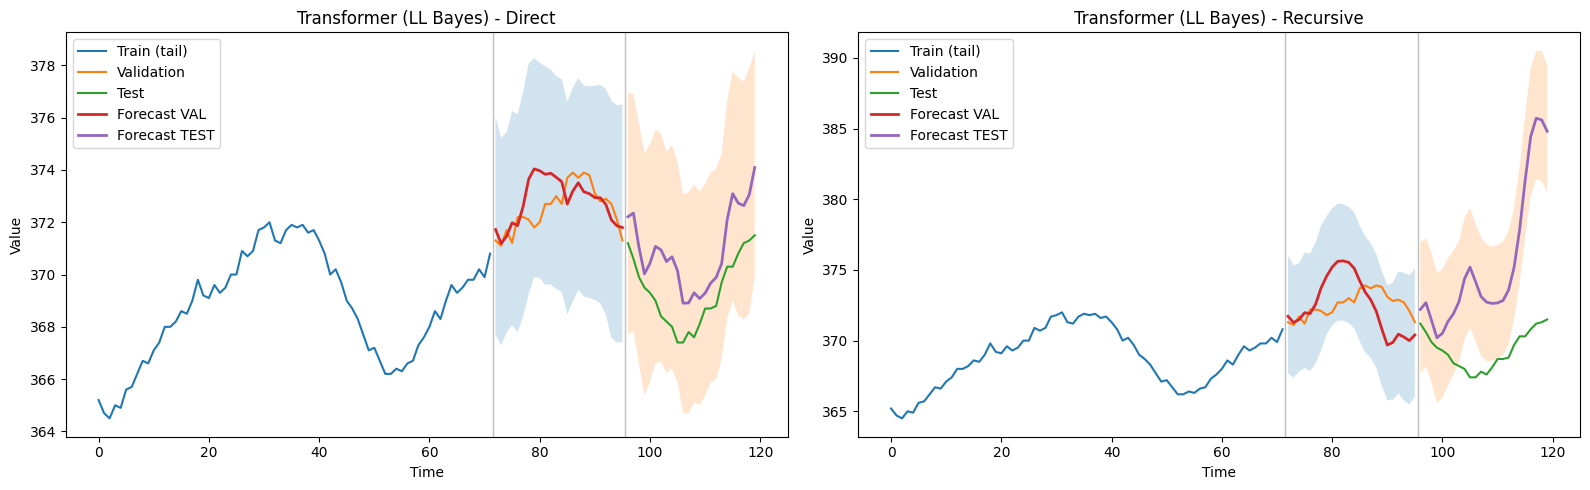

In [31]:
# Run the demo
if __name__ == "__main__":
    _ = demo_workflow(
        use_last_n=1040,
        context_len=52,
        horizon=24,
        standardize=True
    )